In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm import create_model
from timm.loss import LabelSmoothingCrossEntropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
PATH_root = '/media/user/Watson/PanNuke/Classification/'


In [4]:
def load_data(train_batch_size,test_batch_size, PATH):

    transform_train = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.ImageFolder(root=PATH+'train', transform = transform_train)
    # augment batch_size to 64, for example                                        

    testset = datasets.ImageFolder(root=PATH+'test', transform = transform_test)
    
    # augment batch_size to 64, for example                                        
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,shuffle=True, num_workers=6,pin_memory=True)


    # augment batch_size to 64, for example    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,shuffle=False, num_workers=6,pin_memory=True)



    # augment batch_size to 64, for example    
    
    return train_loader, test_loader

In [5]:
def train(log_interval, model, train_loader, optimizer, epoch):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.train()
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_loss = float('inf')
    best_acc = 0
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        output.to(device)
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % log_interval ==1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))  
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted== target.to(device)).sum().item()
    train_loss = running_loss / (batch_idx+1)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    return  train_loss,train_acc,train_losses,train_accs
    

def test(model, test_loader):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            test_loss += F.nll_loss(output, target.to(device), reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_accuracy
    

In [6]:
import os
methods = ['GeomLoss_sinkhorn_target',
 'Reinhard',
 'Ruifrok',
 'GeomLoss_sinkhorn_gradient',
 'model_GAN',
 'model_Net',
 'Macenko',
 'GeomLoss_sinkhorn_Average',
 'GeomLoss_gaussian_Average',
 'Vahadane',
]

['GeomLoss_sinkhorn_target',
 'model_GAN_1',
 'model_Net_1',
 'original',
 'Reinhard',
 'Ruifrok',
 'GeomLoss_sinkhorn_gradient',
 'model_GAN',
 'model_Net',
 'Macenko',
 'GeomLoss_sinkhorn_Average',
 'GeomLoss_gaussian_Average',
 'Vahadane',
 'OT_1D']

In [8]:
classes = os.listdir("/media/user/Watson/PanNuke/Classification/GeomLoss_sinkhorn_Average/train")
classes

['Adrenal_gland',
 'Bile-duct',
 'Bladder',
 'Breast',
 'Cervix',
 'Colon',
 'Esophagus',
 'HeadNeck',
 'Kidney',
 'Liver',
 'Lung',
 'Ovarian',
 'Pancreatic',
 'Prostate',
 'Skin',
 'Stomach',
 'Testis',
 'Thyroid',
 'Uterus']

In [9]:
import pickle

In [10]:
def train(n_epochs, PATH, PATH_output) :
    classes = os.listdir("/media/user/Watson/PanNuke/Classification/GeomLoss_sinkhorn_Average/train")

    trainloader, testloader = load_data(32,32, PATH)# cfg['test_batch_size'])
    model = create_model("tf_efficientnetv2_s", pretrained=True)
    num_ftrs = model.classifier.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(classes))
    )
    model.to(device)

    criterion = LabelSmoothingCrossEntropy()
    optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.001)


    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_loss = float('inf')
    best_acc = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / (i+1)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss +=loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_loss = running_loss / len(testloader)
            test_acc = correct / total
            test_losses.append(test_loss)
            test_accs.append(test_acc)

            print('Epoch: {}  Train Loss: {:.3f}  Train Acc: {:.3f}  Test Loss: {:.3f}  Test Acc: {:.3f}'.format(
                epoch+1, train_loss,train_acc, test_loss, test_acc))

            # Save model if it improves loss and accuracy
            if test_loss < best_loss and test_acc > best_acc:
                torch.save(model.state_dict(), PATH_output+'/best_model_complete.pt')
                best_loss = test_loss
                best_acc = test_acc
                pickle.dump(train_accs, open(PATH_output+'/train_accs.pickle', 'wb'))
                pickle.dump(test_accs, open(PATH_output+'/test_accs.pickle', 'wb'))
                pickle.dump(train_losses, open(PATH_output+'/train_losses.pickle', 'wb'))
                pickle.dump(test_losses, open(PATH_output+'/test_losses.pickle', 'wb'))

            # Adjust learning rate
            scheduler.step(test_loss)

            # Early stopping if the validation loss does not improve
            if epoch > 10 and test_loss > max(test_losses[-5:]):
                print('Early stopping')
                break
   

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score
import pandas as pd


def plot_save(df, PATH, PATH_output, PATH_savefig) :

    transform_test = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainloader, testloader = load_data(32,32, PATH)
    
   # model = torch.load(PATH_output+'/best_model_complete.pt')
    test_accs = pickle.load(open(PATH_output+'/test_accs.pickle', 'rb'))
    train_accs = pickle.load(open(PATH_output+'/train_accs.pickle', 'rb'))
    train_losses = pickle.load(open(PATH_output+'/train_losses.pickle', 'rb'))
    test_losses = pickle.load(open(PATH_output+'/test_losses.pickle', 'rb'))
    
    model = create_model("tf_efficientnetv2_s", pretrained=True)
    num_ftrs = model.classifier.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(classes))
    )
    model.to(device)
    model.load_state_dict(torch.load(PATH_output+'/best_model_complete.pt'))

#  # Plot the accuracy curve
#     plt.plot(test_accs)
#     plt.title('Test accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.show()

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='train')
#     plt.plot(test_losses, label='val')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(train_accs, label='train')
#     plt.plot(test_accs, label='val')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.savefig(PATH_savefig+'/accuracy_loss_class_PCNSL.png')
#     plt.show()
    
    
    num_classes = len(classes)

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    confusion = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:')
    print(confusion)

    # Plot the confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 8))
#     cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     sns.heatmap(cmn, annot=True,  cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)#range(num_classes))

# #    sns.heatmap(cm, annot=True,  cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)#range(num_classes))
#     plt.xlabel("Predicted label")
#     plt.ylabel("True label")
#     plt.savefig(PATH_savefig+"/confusion_matrix_batch24.png")
#     plt.show()
    
    test_data = datasets.ImageFolder(root=PATH+'test', transform = transform_test)
                
# Compute predicted probabilities for test set
    model.eval()
    y_true = np.array(test_data.targets)
    y_scores = np.zeros((len(test_data), len(classes)))
    with torch.no_grad():
        for i, (inputs, _) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_scores[i*32:(i+1)*32] = nn.functional.softmax(outputs, dim=1).cpu().numpy()

    # Compute AUC curves and plot
    
    y_score = []
    for i in y_scores :
        y_score.append(np.argmax(i))
    y_score = np.array(y_score)

    
   # plt.figure(figsize=(8, 8))
    for i in range(len(classes)):
        tn, fp, fn, tp = confusion_matrix((y_true == i).astype(int), (y_score == i).astype(int)).ravel()
        fpr, tpr, thresholds = roc_curve((y_true == i).astype(int),(y_score == i).astype(int))
        roc_auc = auc(fpr, tpr)
        
        
        
        
#         accuracy = (tp + tn) / (tp + fp + fn + tn)
#         f1 = f1_score((y_true == i).astype(int), (y_score == i).astype(int), average='weighted')
#         precision = precision_score((y_true == i).astype(int), (y_score == i).astype(int), average='weighted')
#         recall = recall_score((y_true == i).astype(int), (y_score == i).astype(int), average='weighted')
#         specificity = tn / (tn + fp)
#         plt.plot(fpr, tpr, label='{} (AUC = {:.3f})'.format(classes[i], roc_auc))
        # Compute AUC curves and plot
#        df_temp = pd.DataFrame({'method':[method], 'AUC_'+'{}'.format(classes[i]) : [round(roc_auc, 2)], 'F1_'+'{}'.format(classes[i]) : [round(f1, 2)], 'Precision_'+'{}'.format(classes[i]) : [round(precision, 2)], 'Specificity_'+'{}'.format(classes[i]) : [round(specificity, 2)], 'Recall_'+'{}'.format(classes[i]) : [round(recall, 2)]})#, 'AUC_G2' : [round(roc_auc_2, 2)], 'AUC_G3' : [round(roc_auc_2, 2)]})
        df_temp = pd.DataFrame({'method':[method], 'dataset':[classes[i]], 'AUC' : [round(roc_auc, 2)]})#, 'F1': [round(f1, 2)], 'Precision': [round(precision, 2)], 'Specificity': [round(specificity, 2)], 'Recall': [round(recall, 2)], 'Accuracy': [round(accuracy, 2)]})#, 'AUC_G2' : [round(roc_auc_2, 2)], 'AUC_G3' : [round(roc_auc_2, 2)]})
    
        df = pd.concat([df, df_temp])      


    
#     plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('Receiver operating characteristic')
#     plt.legend()
#     plt.savefig(PATH_savefig+'/ROC_AUC_curves_PCNSL_batch32.png')
#     plt.show()
    
    
#     for i in range(len(classes)):
#         precision, recall, thresholds = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
#         avg_precision = average_precision_score((y_true == i).astype(int), y_scores[:, i])
#         plt.plot(recall, precision, label='{} (AP = {:.3f})'.format(classes[i], avg_precision))
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision-Recall curve')
#     plt.legend()
#     plt.savefig(PATH_savefig+'/precision_recall_curves_PCNSL_batch32.png')
#     plt.show()

    return df

In [16]:
def bootstrap_auc(clf, X_train, y_train, X_test, y_test, nsamples=1000):
    auc_values = []
    for b in range(nsamples):
        idx = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        clf.fit(X_train[idx], y_train[idx])
        pred = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test.ravel(), pred.ravel())
        auc_values.append(roc_auc)
    return np.percentile(auc_values, (2.5, 97.5))

In [17]:
import numpy as np
from sklearn.metrics import recall_score, f1_score
df = pd.DataFrame()#{'method':[],'AUC_G2':[],'AUC_G3':[],'AUC_G4':[]})
for method in methods :
    print('------------------', method,'------------------' )
    PATH = PATH_root+method+'/'
    PATH_output = '/media/user/Watson/PanNuke/metrics/Classification_tissu/'+method
    PATH_savefig= '/media/user/Watson/PanNuke/plot_article/Classification_tissu/'+method
    if not os.path.exists(PATH_savefig) :
        os.mkdir(PATH_savefig)
    df = plot_save(df, PATH, PATH_output, PATH_savefig)

------------------ GeomLoss_sinkhorn_target ------------------
Confusion matrix:
[[  6   2   1  45   1  17   4   4   1   1   0   0   1   0   0   1   0   3
    1]
 [  2   8   0  41   2  12   1   4   1   7   0   0   0   2   1   1   1   1
    0]
 [  0   1   8  10   1   2   0   2   0   0   1   0   1   0   1   1   1   1
    0]
 [ 18  17   4 252  10  68  12  21   8   7   4   6   5   6   8   4   9   4
    8]
 [  1   2   1  24   4  13   2   1   1   2   3   1   1   0   1   1   0   1
    0]
 [  9   6   5 135   7  55   9  20   3   1   5   4   7   1   4   2   5   7
    3]
 [  4   4   0  36   1  15  10   3   2   2   1   1   2   0   1   1   0   1
    1]
 [  0   5   1  31   1  24   1   3   0   0   1   0   0   3   1   0   4   1
    1]
 [  0   1   0  11   3   5   0   1   3   0   1   0   0   1   0   0   0   0
    1]
 [  4   3   1  24   1   5   2   1   0   2   0   0   1   0   0   0   1   0
    0]
 [  0   0   1  10   2  13   0   3   0   0   7   0   0   1   0   0   0   0
    0]
 [  1   1   0  19   2   3   

------------------ model_Net ------------------
Confusion matrix:
[[  6   3   2  38   3  18   0   9   0   3   0   0   1   0   0   1   1   3
    0]
 [  3   9   1  38   2  13   2   3   0   2   1   1   1   0   3   1   1   3
    0]
 [  4   2   4   8   0   4   1   1   0   1   2   1   0   0   1   0   0   0
    1]
 [ 15  18   5 244  14  69  18  16   3  11   4   3   9   3   8   5   9   9
    8]
 [  2   0   1  28   4   5   3   5   0   0   0   0   2   1   2   1   0   2
    3]
 [ 12   8   2 132   6  61  11  11   5   2   6   2   6   7   5   3   4   3
    2]
 [  4   4   1  32   4  13  12   2   1   1   0   0   4   1   1   2   2   1
    0]
 [  2   3   2  24   2  21   2  11   0   0   0   1   1   0   3   2   0   3
    0]
 [  0   0   0  13   0   3   3   1   3   0   0   0   0   0   0   0   1   1
    2]
 [  5   3   0  18   1   6   0   4   0   3   0   1   0   0   2   0   0   1
    1]
 [  0   1   0  15   0   8   1   4   0   0   5   1   0   0   2   0   0   0
    0]
 [  0   2   0  15   1   4   1   0   0   0  

In [18]:
df_tot = df[['method', 'dataset', 'AUC']]
df_tot

,method,dataset,AUC
0,GeomLoss_sinkhorn_target,Adrenal_gland,0.95
0,GeomLoss_sinkhorn_target,Bile-duct,0.89
0,GeomLoss_sinkhorn_target,Bladder,0.80
0,GeomLoss_sinkhorn_target,Breast,0.96
0,GeomLoss_sinkhorn_target,Cervix,0.93
...,...,...,...
0,Vahadane,Skin,0.82
0,Vahadane,Stomach,0.82
0,Vahadane,Testis,0.74
0,Vahadane,Thyroid,0.85


In [20]:
methods.remove('original')

In [21]:
for method in methods[:1] :
    print(method)
    df_temp = df_tot[df_tot['method']==method]
    #df_temp.set_index('dataset',inplace=True)
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'AUC':method},inplace=True)
    df_auc = df_temp


GeomLoss_sinkhorn_target


/tmp/ipykernel_28568/1792134866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_28568/1792134866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'AUC':method},inplace=True)


In [22]:

for method in methods[1:] :
    print(method)
    df_temp = df_tot[df_tot['method']==method]
   # df_temp.set_index('dataset',inplace=True)
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'AUC':method},inplace=True)
    df_auc = pd.merge(df_auc, df_temp, on='dataset')
df_auc

Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane


/tmp/ipykernel_28568/4083969062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_28568/4083969062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'AUC':method},inplace=True)
/tmp/ipykernel_28568/4083969062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_28568/4083969062.py:6: SettingWi

,dataset,GeomLoss_sinkhorn_target,Reinhard,Ruifrok,GeomLoss_sinkhorn_gradient,model_GAN,model_Net,Macenko,GeomLoss_sinkhorn_Average,Vahadane
0,Adrenal_gland,0.95,0.92,0.89,0.95,0.93,0.90,0.85,0.96,0.88
1,Bile-duct,0.89,0.83,0.86,0.90,0.81,0.80,0.70,0.84,0.83
2,Bladder,0.80,0.81,0.82,0.78,0.80,0.77,0.80,0.82,0.87
3,Breast,0.96,0.93,0.93,0.95,0.92,0.93,0.91,0.95,0.93
4,Cervix,0.93,0.85,0.87,0.95,0.88,0.87,0.86,0.88,0.84
5,Colon,0.99,0.97,0.97,0.99,0.97,0.99,0.96,0.99,0.97
6,Esophagus,0.89,0.81,0.84,0.88,0.87,0.91,0.80,0.82,0.86
7,HeadNeck,0.93,0.84,0.88,0.92,0.82,0.89,0.84,0.90,0.89
8,Kidney,0.94,0.93,0.87,0.98,0.78,0.85,0.89,0.96,0.91
9,Liver,0.85,0.86,0.69,0.89,0.81,0.68,0.80,0.81,0.80


In [37]:
df_auc_stock = df_auc.copy()

In [44]:
df_auc

,GeomLoss_sinkhorn_target,Reinhard,Ruifrok,GeomLoss_sinkhorn_gradient,model_GAN,model_Net,Macenko,GeomLoss_sinkhorn_Average,Vahadane
dataset,,,,,,,,,
Adrenal_gland,0.95,0.92,0.89,0.95,0.93,0.90,0.85,0.96,0.88
Bile-duct,0.89,0.83,0.86,0.90,0.81,0.80,0.70,0.84,0.83
Bladder,0.80,0.81,0.82,0.78,0.80,0.77,0.80,0.82,0.87
Breast,0.96,0.93,0.93,0.95,0.92,0.93,0.91,0.95,0.93
Cervix,0.93,0.85,0.87,0.95,0.88,0.87,0.86,0.88,0.84
Colon,0.99,0.97,0.97,0.99,0.97,0.99,0.96,0.99,0.97
Esophagus,0.89,0.81,0.84,0.88,0.87,0.91,0.80,0.82,0.86
HeadNeck,0.93,0.84,0.88,0.92,0.82,0.89,0.84,0.90,0.89
Kidney,0.94,0.93,0.87,0.98,0.78,0.85,0.89,0.96,0.91


In [49]:
df_auc

,GeomLoss_sinkhorn_target,Reinhard,Ruifrok,GeomLoss_sinkhorn_gradient,model_GAN,model_Net,Macenko,GeomLoss_sinkhorn_Average,Vahadane
dataset,,,,,,,,,
Adrenal_gland,0.95,0.92,0.89,0.95,0.93,0.90,0.85,0.96,0.88
Bile-duct,0.89,0.83,0.86,0.90,0.81,0.80,0.70,0.84,0.83
Bladder,0.80,0.81,0.82,0.78,0.80,0.77,0.80,0.82,0.87
Breast,0.96,0.93,0.93,0.95,0.92,0.93,0.91,0.95,0.93
Cervix,0.93,0.85,0.87,0.95,0.88,0.87,0.86,0.88,0.84
Colon,0.99,0.97,0.97,0.99,0.97,0.99,0.96,0.99,0.97
Esophagus,0.89,0.81,0.84,0.88,0.87,0.91,0.80,0.82,0.86
HeadNeck,0.93,0.84,0.88,0.92,0.82,0.89,0.84,0.90,0.89
Kidney,0.94,0.93,0.87,0.98,0.78,0.85,0.89,0.96,0.91


/home/user/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'AUC PanNuke')

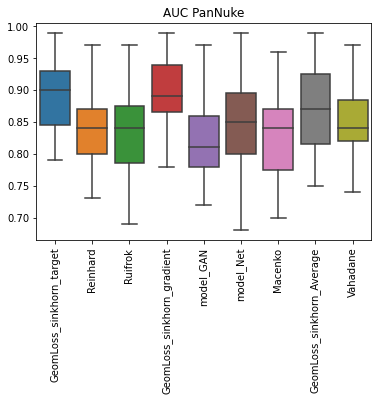

In [56]:
import seaborn as sns
ax = sns.boxplot(data= df_auc)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('AUC PanNuke')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after

In [89]:
df = df_auc.loc[['std']]
liste = []
liste_valeurs = []
for i in list(df.columns) :
    if len(liste) == 0 :
        liste.append(i)
        liste_valeurs.append(df.at['std', i])
    else :
        value = df.at['std', i]
        bisect.insort(liste_valeurs, value)
        ind = liste_valeurs.index(value)
        liste.insert(ind, i)
        

In [82]:
df_auc.loc[['std']]

,GeomLoss_sinkhorn_target,Reinhard,Ruifrok,GeomLoss_sinkhorn_gradient,model_GAN,model_Net,Macenko,GeomLoss_sinkhorn_Average,Vahadane
dataset,,,,,,,,,
std,0.058694,0.065476,0.07402,0.064245,0.06708,0.083382,0.073933,0.074782,0.06177


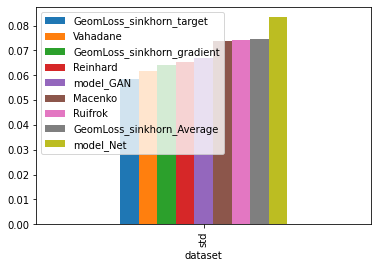

In [93]:
axes = df.plot.bar()
axes.legend(loc=2) 